In [1]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

In [2]:
import glob 
import numpy as np 
import os 
import shutil 

from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img 
np.random.seed(42) 

import matplotlib.pyplot as plt 
%matplotlib inline 

Using TensorFlow backend.


In [3]:
files = glob.glob('data/train/*') 
 
cat_files = [fn for fn in files if 'cat' in fn] 
dog_files = [fn for fn in files if 'dog' in fn] 
len(cat_files), len(dog_files)

(12500, 12500)

In [4]:
cat_train = np.random.choice(cat_files, size=1500, replace=False) 
dog_train = np.random.choice(dog_files, size=1500, replace=False) 
cat_files = list(set(cat_files) - set(cat_train)) 
dog_files = list(set(dog_files) - set(dog_train)) 
 
cat_val = np.random.choice(cat_files, size=500, replace=False) 
dog_val = np.random.choice(dog_files, size=500, replace=False) 
cat_files = list(set(cat_files) - set(cat_val)) 
dog_files = list(set(dog_files) - set(dog_val)) 
 
cat_test = np.random.choice(cat_files, size=500, replace=False) 
dog_test = np.random.choice(dog_files, size=500, replace=False) 
 
print('Cat datasets:', cat_train.shape, cat_val.shape, cat_test.shape) 
print('Dog datasets:', dog_train.shape, dog_val.shape, dog_test.shape) 

Cat datasets: (1500,) (500,) (500,)
Dog datasets: (1500,) (500,) (500,)


In [5]:
train_dir = 'data/training_data' 
val_dir = 'data/validation_data' 
test_dir = 'data/test_data' 
 
train_files = np.concatenate([cat_train, dog_train]) 
validate_files = np.concatenate([cat_val, dog_val]) 
test_files = np.concatenate([cat_test, dog_test]) 
 
os.mkdir(train_dir) if not os.path.isdir(train_dir) else None 
os.mkdir(val_dir) if not os.path.isdir(val_dir) else None 
os.mkdir(test_dir) if not os.path.isdir(test_dir) else None 
 
for fn in train_files: 
    shutil.copy(fn, train_dir) 
for fn in validate_files: 
    shutil.copy(fn, val_dir) 
for fn in test_files: 
    shutil.copy(fn, test_dir) 

In [11]:
IMG_DIM = (150, 150) 
 
train_files = glob.glob('data/training_data/*') 
train_imgs = [img_to_array(load_img(img, target_size=IMG_DIM)) for img  
              in train_files] 
train_imgs = np.array(train_imgs) 
train_labels = [fn.split('\\')[1].split('.')[0].strip() for fn in 
                train_files] 
 
validation_files = glob.glob('data/validation_data/*') 
validation_imgs = [img_to_array(load_img(img, target_size=IMG_DIM)) for 
                   img in validation_files] 
validation_imgs = np.array(validation_imgs) 
validation_labels = [fn.split('\\')[1].split('.')[0].strip() for fn in 
                     validation_files] 
 
print('Train dataset shape:', train_imgs.shape,  
      'Validation dataset shape:', validation_imgs.shape) 

Train dataset shape: (3000, 150, 150, 3) Validation dataset shape: (1000, 150, 150, 3)


#### Scale each image with pixel values between (0, 255) to values between (0, 1) because deep learning models work really well with small input values

(150, 150, 3)


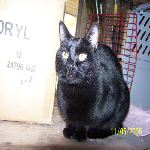

In [12]:
train_imgs_scaled = train_imgs.astype('float32') 
validation_imgs_scaled = validation_imgs.astype('float32') 
train_imgs_scaled /= 255 
validation_imgs_scaled /= 255 
 
# visualize a sample image 
print(train_imgs[0].shape) 
array_to_img(train_imgs[0]) 

#### basic configuration parameters and also encode our text class labels into numeric values (otherwise, Keras will throw an error):

In [13]:
batch_size = 30 
num_classes = 2 
epochs = 30 
input_shape = (150, 150, 3) 
 
# encode text category labels 
from sklearn.preprocessing import LabelEncoder 
 
le = LabelEncoder() 
le.fit(train_labels) 
train_labels_enc = le.transform(train_labels) 
validation_labels_enc = le.transform(validation_labels) 
 
print(train_labels[1495:1505], train_labels_enc[1495:1505]) 

['cat', 'cat', 'cat', 'cat', 'cat', 'dog', 'dog', 'dog', 'dog', 'dog'] [0 0 0 0 0 1 1 1 1 1]


In [14]:
train_datagen = ImageDataGenerator(rescale=1./255, zoom_range=0.3,  
                                   rotation_range=50, 
                                   width_shift_range=0.2,  
                                   height_shift_range=0.2,   
                                   shear_range=0.2,  
                                   horizontal_flip=True,   
                                   fill_mode='nearest') 
 
val_datagen = ImageDataGenerator(rescale=1./255) 

Labels: ['dog', 'dog', 'dog', 'dog', 'dog']


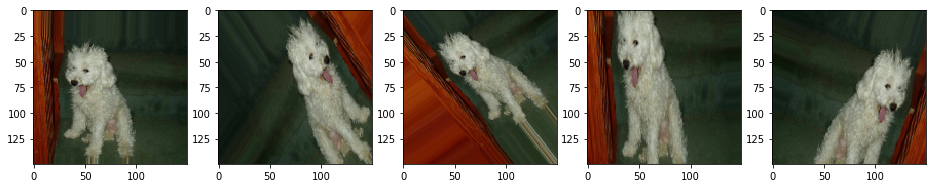

In [15]:
img_id = 2595 
cat_generator = train_datagen.flow(train_imgs[img_id:img_id+1],  
                                   train_labels[img_id:img_id+1], 
                                   batch_size=1) 
cat = [next(cat_generator) for i in range(0,5)] 
fig, ax = plt.subplots(1,5, figsize=(16, 6)) 
print('Labels:', [item[1][0] for item in cat]) 
l = [ax[i].imshow(cat[i][0][0]) for i in range(0,5)] 

Pretrained models are used in the following two popular ways when building new models or reusing them:

    Using a pretrained model as a feature extractor
    Fine-tuning the pretrained model


# Pretrained CNN model as a feature extractor

In [16]:
from keras.applications import vgg16 
from keras.models import Model 
import keras 
 
vgg = vgg16.VGG16(include_top=False, weights='imagenet',  
                                     input_shape=input_shape) 

# we have removed the final part of the classifier pertaining to the VGG-16 model 
#since we will be building our own classifier and leveraging VGG as a feature extractor
output = vgg.layers[-1].output 
output = keras.layers.Flatten()(output) 
vgg_model = Model(vgg.input, output) 
vgg_model.trainable = False 
 
for layer in vgg_model.layers: 
    layer.trainable = False 

vgg_model.summary()

58892288/58889256 [==============================] - 7s 0us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool

In [18]:
# To verify that the layers of the VGG-16 model are frozen, we can use the following code:
import pandas as pd 
pd.set_option('max_colwidth', -1) 
 
layers = [(layer, layer.name, layer.trainable) for layer in 
           vgg_model.layers] 
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])

,Layer Type,Layer Name,Layer Trainable
0,<keras.engine.input_layer.InputLayer object at 0x00000121DFE4A978>,input_1,False
1,<keras.layers.convolutional.Conv2D object at 0x00000121DFE1B320>,block1_conv1,False
2,<keras.layers.convolutional.Conv2D object at 0x00000121DFE4A080>,block1_conv2,False
3,<keras.layers.pooling.MaxPooling2D object at 0x00000121DFBDA160>,block1_pool,False
4,<keras.layers.convolutional.Conv2D object at 0x00000121DFBDA860>,block2_conv1,False
5,<keras.layers.convolutional.Conv2D object at 0x00000121DFBF06D8>,block2_conv2,False
6,<keras.layers.pooling.MaxPooling2D object at 0x00000121DFC098D0>,block2_pool,False
7,<keras.layers.convolutional.Conv2D object at 0x00000121DFC09358>,block3_conv1,False
8,<keras.layers.convolutional.Conv2D object at 0x00000121DFC3DDA0>,block3_conv2,False
9,<keras.layers.convolutional.Conv2D object at 0x00000121DFC58E10>,block3_conv3,False


In [19]:
print("Trainable layers:", vgg_model.trainable_weights)

Trainable layers: []


#### It is quite clear from the preceding output that all the layers of the VGG-16 model are frozen, which is good because we don't want their weights to change during model training.

### The last activation feature map in the VGG-16 model (output from block5_pool) gives us the bottleneck features, which can then be flattened and fed to a fully connected deep neural network classifier. The following snippet shows what the bottleneck features look like for a sample image from our training data:

(1, 4, 4, 512)


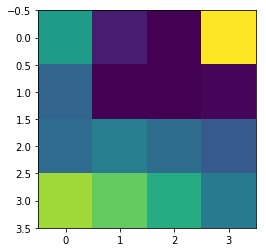

In [20]:
bottleneck_feature_example = vgg.predict(train_imgs_scaled[0:1])
print(bottleneck_feature_example.shape) 
plt.imshow(bottleneck_feature_example[0][:,:,0]) 

#### We flatten the bottleneck features in the vgg_model object to make them ready to be fed to our fully connected classifier. 

#### A way to save time in model training is to use this model and extract out all the features from our training and validation datasets and then feed them as inputs to our classifier. 

##### Let's extract out the bottleneck features from our training and validation sets now:

In [22]:
def get_bottleneck_features(model, input_imgs): 
    features = model.predict(input_imgs, verbose=0) 
    return features 

train_features_vgg = get_bottleneck_features(vgg_model, 
                                             train_imgs_scaled) 
validation_features_vgg = get_bottleneck_features(vgg_model,      
                                                validation_imgs_scaled) 

print('Train Bottleneck Features:', train_features_vgg.shape, 
      '\tValidation Bottleneck Features:', validation_features_vgg.shape) 

Train Bottleneck Features: (3000, 8192) 	Validation Bottleneck Features: (1000, 8192)


#### The preceding output tells us that we have successfully extracted the flattened bottleneck features of dimension 1 x 8,192 for our 3,000 training images and our 1,000 validation images. 

##### Let's build the architecture of our deep neural network classifier now, which will take these features as input:

In [23]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer 
from keras.models import Sequential 
from keras import optimizers 

input_shape = vgg_model.output_shape[1] 
model = Sequential() 
model.add(InputLayer(input_shape=(input_shape,))) 
model.add(Dense(512, activation='relu', input_dim=input_shape)) 
model.add(Dropout(0.3)) 
model.add(Dense(512, activation='relu')) 
model.add(Dropout(0.3)) 
model.add(Dense(1, activation='sigmoid')) 

model.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(lr=1e-4), metrics=['accuracy']) 
model.summary() 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               4194816   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 513       
Total params: 4,457,985
Trainable params: 4,457,985
Non-trainable params: 0
_________________________________________________________________


### bottleneck feature vectors of size 8192 serve as input to our classification model

In [24]:
history = model.fit(x=train_features_vgg, y=train_labels_enc, 
                    validation_data=(validation_features_vgg, validation_labels_enc),  
                    batch_size=batch_size, epochs=epochs, verbose=1) 

Train on 3000 samples, validate on 1000 samples
Epoch 1/30
3000/3000 [==============================] - 7s 2ms/step - loss: 0.4376 - acc: 0.7890 - val_loss: 0.2973 - val_acc: 0.8730
Epoch 2/30
3000/3000 [==============================] - 6s 2ms/step - loss: 0.2858 - acc: 0.8823 - val_loss: 0.2777 - val_acc: 0.8910
Epoch 3/30
3000/3000 [==============================] - 7s 2ms/step - loss: 0.2451 - acc: 0.9007 - val_loss: 0.2860 - val_acc: 0.8890
Epoch 4/30
3000/3000 [==============================] - 6s 2ms/step - loss: 0.2057 - acc: 0.9147 - val_loss: 0.2748 - val_acc: 0.8930
Epoch 5/30
3000/3000 [==============================] - 6s 2ms/step - loss: 0.1739 - acc: 0.9263 - val_loss: 0.3744 - val_acc: 0.8640
Epoch 6/30
3000/3000 [==============================] - 6s 2ms/step - loss: 0.1469 - acc: 0.9443 - val_loss: 0.2973 - val_acc: 0.9030
Epoch 7/30
3000/3000 [==============================] - 6s 2ms/step - loss: 0.1242 - acc: 0.9510 - val_loss: 0.3522 - val_acc: 0.8810
Epoch 8/30
300

In [ ]:
# model.save('cats_dogs_tlearn_basic_cnn.h5')

# Pretrained CNN model as a feature extractor with image augmentation

In [25]:
train_datagen = ImageDataGenerator(rescale=1./255, zoom_range=0.3, 
                                   rotation_range=50,   
                                   width_shift_range=0.2,  
                                   height_shift_range=0.2, 
                                   shear_range=0.2, 
                                   horizontal_flip=True,  
                                   fill_mode='nearest') 

val_datagen = ImageDataGenerator(rescale=1./255) 
train_generator = train_datagen.flow(train_imgs, train_labels_enc, 
                                     batch_size=30) 
val_generator = val_datagen.flow(validation_imgs, 
                                 validation_labels_enc, 
                                 batch_size=20)

In [28]:
model = Sequential() 

model.add(vgg_model) 
model.add(Dense(512, activation='relu', input_dim=input_shape)) 
model.add(Dropout(0.3)) 
model.add(Dense(512, activation='relu')) 
model.add(Dropout(0.3)) 
model.add(Dense(1, activation='sigmoid')) 

model.compile(loss='binary_crossentropy', 
              optimizer=optimizers.RMSprop(lr=2e-5), 
              metrics=['accuracy'])

In [29]:
history = model.fit_generator(train_generator, 
                              steps_per_epoch=100,
                              validation_data=val_generator, 
                              validation_steps=50, 
                              verbose=1) 

Epoch 1/1
100/100 [==============================] - 870s 9s/step - loss: 0.6295 - acc: 0.6400 - val_loss: 0.4737 - val_acc: 0.8080
